# Relax Challenge

**Goal:** Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period , identify which factors predict future user
adoption

# Imports

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline

# Loading the data and information of the data

## takehome_users.csv

In [2]:
path = '/content/drive/MyDrive/Springboard/searching job/relax_challenge'
users = pd.read_csv(path+'/takehome_users.csv', sep=',', encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users.shape

(12000, 10)

## takehome_user_engagement.csv

In [4]:
user_engagement = pd.read_csv(path+'/takehome_user_engagement.csv', sep=',', encoding='latin-1')
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
user_engagement.shape

(207917, 3)

In [6]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


# Create a 'login_df' dataframe
* with one column of user id, and an other column 'Y' indicating if the user login in 3 difference days in at least one 7-day-period

In [7]:
user_engagement['time_stamp'] = pd.to_datetime(user_engagement.time_stamp)

In [8]:
df = user_engagement.groupby('user_id').apply(lambda x: x.sort_values('time_stamp')).set_index(user_engagement.index)

In [9]:
df['time_stamp_diff1']=df.groupby('user_id')['time_stamp'].diff(1).dt.days.shift(1)
df['time_stamp_diff2']=df.groupby('user_id')['time_stamp'].diff(2).dt.days
df.head()

,time_stamp,user_id,visited,time_stamp_diff1,time_stamp_diff2
0,2014-04-22 03:53:30,1,1,NaN,NaN
1,2013-11-15 03:45:04,2,1,NaN,NaN
2,2013-11-29 03:45:04,2,1,NaN,NaN
3,2013-12-09 03:45:04,2,1,14.0,24.0
4,2013-12-25 03:45:04,2,1,10.0,26.0


In [10]:
func = lambda x: sum((x.time_stamp_diff1>=1) & (x.time_stamp_diff2<=7))>=1
s = df.groupby('user_id').apply(func)

login_df = pd.DataFrame({'user_id': s.index, 'adopted_user':s.values.astype('int')})
login_df.head()

,user_id,adopted_user
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


# Combine the users and login_df dataframe

In [11]:
users = users.merge(login_df, left_on='object_id', right_on='user_id').drop('object_id', axis=1)
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted_user
0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0
1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2,1
2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,0
3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4,0
4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5,0


### Check info

In [12]:
users.shape

(8823, 11)

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               8823 non-null   object 
 1   name                        8823 non-null   object 
 2   email                       8823 non-null   object 
 3   creation_source             8823 non-null   object 
 4   last_session_creation_time  8823 non-null   float64
 5   opted_in_to_mailing_list    8823 non-null   int64  
 6   enabled_for_marketing_drip  8823 non-null   int64  
 7   org_id                      8823 non-null   int64  
 8   invited_by_user_id          4776 non-null   float64
 9   user_id                     8823 non-null   int64  
 10  adopted_user                8823 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 827.2+ KB


In [14]:
users.isnull().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
user_id                          0
adopted_user                     0
dtype: int64

In [15]:
users.describe()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted_user
count,8.823000e+03,8823.000000,8823.000000,8823.000000,4776.000000,8823.000000,8823.000000
mean,1.379279e+09,0.252295,0.151989,142.572254,5980.495394,6019.821716,0.187691
std,1.953116e+07,0.434354,0.359031,124.176422,3394.211361,3464.251001,0.390488
min,1.338452e+09,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000
25%,1.363195e+09,0.000000,0.000000,30.000000,3071.000000,3017.500000,0.000000
50%,1.382888e+09,0.000000,0.000000,109.000000,5947.000000,6034.000000,0.000000
75%,1.398443e+09,1.000000,0.000000,239.000000,8857.250000,9029.500000,0.000000
max,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,12000.000000,1.000000


# Clean the data

### Drop the some features that are not useful 

In [16]:
df = users.drop(['creation_time','name','email','invited_by_user_id','user_id'], axis=1)

In [17]:
df.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user
0,GUEST_INVITE,1.398139e+09,1,0,11,0
1,ORG_INVITE,1.396238e+09,0,0,1,1
2,ORG_INVITE,1.363735e+09,0,0,94,0
3,GUEST_INVITE,1.369210e+09,0,0,1,0
4,GUEST_INVITE,1.358850e+09,0,0,193,0


# EDA

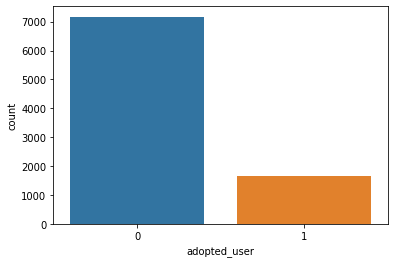

In [18]:
sns.countplot(x='adopted_user', data=df)

In [19]:
sum(df.adopted_user)/len(df)

0.18769126147568854

* Date set is imbalance, only about 18.8% of the observations are adopted users. 

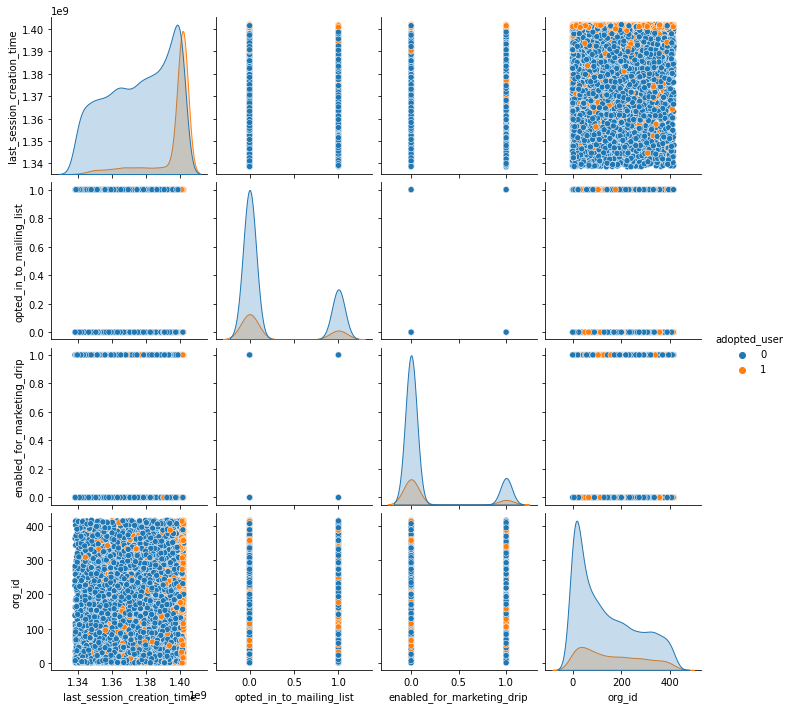

In [20]:
sns.pairplot(df, hue='adopted_user')

* Can not find any clear pattern to show the relationship between any two features

In [21]:
df.columns

Index(['creation_source', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'adopted_user'],
      dtype='object')

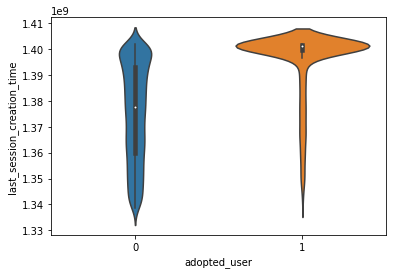

In [22]:
sns.violinplot(y='last_session_creation_time', x = 'adopted_user', data=df)

* For the distribution of 'last_session_creation_time', most 'adopted_user' identified as 1 are distributed at around 140. The 'adopted_user' 0 are evenly distributed.

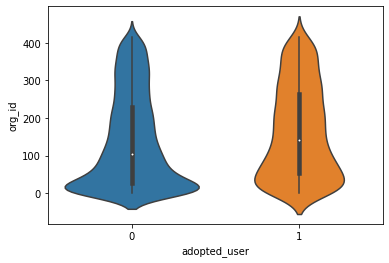

In [23]:
sns.violinplot(y='org_id', x = 'adopted_user', data=df)

* The distribution of 'org_id' sorted by 'adopted_user' 1 and 0 are similar to each other.

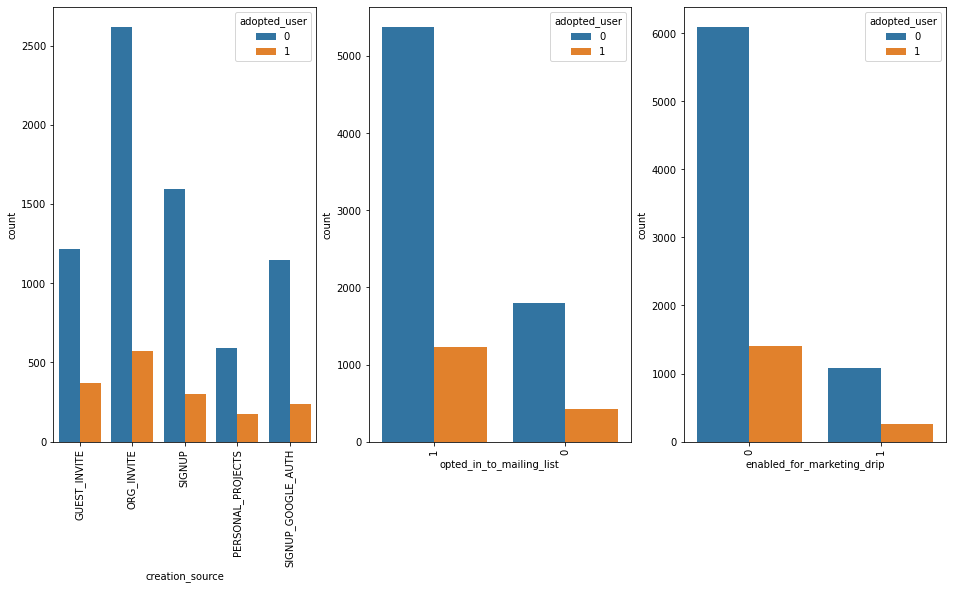

In [43]:
cols = ['creation_source','opted_in_to_mailing_list', 'enabled_for_marketing_drip']

fig, axs = plt.subplots(1, 3, figsize=[16,8])

for col, ax in zip(cols, axs):
  g = sns.countplot(hue='adopted_user', x=col, data=df, ax=ax)
  g.set_xticklabels(rotation=90, labels=df[col].unique())
fig.show()

* The distribution of each features from the countplots above sorted by 'adopted_user' 1 and 0 are still similar to each other.

# Pre-processing

### Create X and y, and get dummy vairables

In [44]:
y = df.adopted_user
X = df.drop(columns='adopted_user', axis=1)
X = pd.get_dummies(X)

In [45]:
X.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1,0,11,1,0,0,0,0
1,1.396238e+09,0,0,1,0,1,0,0,0
2,1.363735e+09,0,0,94,0,1,0,0,0
3,1.369210e+09,0,0,1,1,0,0,0,0
4,1.358850e+09,0,0,193,1,0,0,0,0


In [55]:
X.shape

(8823, 9)

### Get train and test set

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Model: Gradient Boosting Classifier

In [51]:
GBC_pipe = make_pipeline(
    SelectKBest(f_regression),
    GradientBoostingClassifier())

GBC_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'gradientboostingclassifier', 'selectkbest__k', 'selectkbest__score_func', 'gradientboostingclassifier__ccp_alpha', 'gradientboostingclassifier__criterion', 'gradientboostingclassifier__init', 'gradientboostingclassifier__learning_rate', 'gradientboostingclassifier__loss', 'gradientboostingclassifier__max_depth', 'gradientboostingclassifier__max_features', 'gradientboostingclassifier__max_leaf_nodes', 'gradientboostingclassifier__min_impurity_decrease', 'gradientboostingclassifier__min_impurity_split', 'gradientboostingclassifier__min_samples_leaf', 'gradientboostingclassifier__min_samples_split', 'gradientboostingclassifier__min_weight_fraction_leaf', 'gradientboostingclassifier__n_estimators', 'gradientboostingclassifier__n_iter_no_change', 'gradientboostingclassifier__presort', 'gradientboostingclassifier__random_state', 'gradientboostingclassifier__subsample', 'gradientboostingclassifier__tol', 'gradientboostingclassifier__val

In [52]:
#k = [i for i in range(1, len(X_train.columns)+1)]

param_grid = {'selectkbest__k':k, 
              'gradientboostingclassifier__learning_rate':[0.09,0.10,0.11], 
              'gradientboostingclassifier__n_estimators':[70, 100, 150],
              'gradientboostingclassifier__max_depth':[5,7,9],
              'gradientboostingclassifier__max_features':['auto', 'sqrt', 'log2']
              }

GBC_gird_cv = GridSearchCV(GBC_pipe, 
                           param_grid,
                           scoring = 'f1',
                           cv=5,
                           n_jobs=-1)
GBC_gird_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=10,
                                                    score_func=<function f_regression at 0x7f2ad2f4c950>)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                                       

* Use f1-score as the metric because of the data imbalance.

In [53]:
GBC_gird_cv.best_score_

0.6695951096355431

In [54]:
GBC_gird_cv.best_params_

{'gradientboostingclassifier__learning_rate': 0.09,
 'gradientboostingclassifier__max_depth': 5,
 'gradientboostingclassifier__max_features': 'sqrt',
 'gradientboostingclassifier__n_estimators': 70,
 'selectkbest__k': 8}

* Total number of features are 9, the best selection is 8, no big difference. So I decided use all the features to train the model agrain since we need to figure out the feature importance. I will all fine tune the hyperparameter base on the result of best parameters to get the optimal result. 

In [129]:
GBC = GradientBoostingClassifier(learning_rate=0.09, max_depth=4, max_features='sqrt', n_estimators=60)

GBC.fit(X_train, y_train)
y_pred = GBC.predict(X_test)

Text(33.0, 0.5, 'True Label')

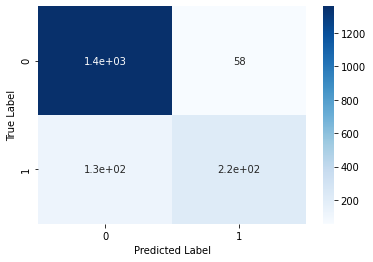

In [130]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [131]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1417
           1       0.79      0.64      0.70       348

    accuracy                           0.90      1765
   macro avg       0.85      0.80      0.82      1765
weighted avg       0.89      0.90      0.89      1765



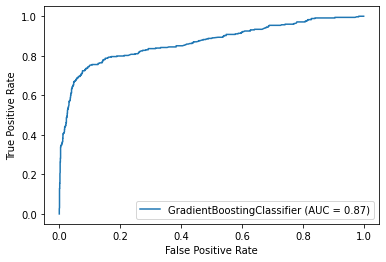

In [132]:
ax = plt.gca()
fig = plot_roc_curve(GBC, X_test,y_test,ax=ax)
plt.show()

* The model get a average f1-score=0.82 and  AUC=0.87 for roc curve.

# Feature importance

In [81]:
feature_importances_df = pd.DataFrame({"feature": X.columns, "feature_importances": GBC.feature_importances_})
feature_importances_df = feature_importances_df.sort_values("feature_importances", ascending=False)
feature_importances_df

,feature,feature_importances
0,last_session_creation_time,0.914826
3,org_id,0.061762
2,enabled_for_marketing_drip,0.007006
1,opted_in_to_mailing_list,0.004690
4,creation_source_GUEST_INVITE,0.003318
7,creation_source_SIGNUP,0.003203
5,creation_source_ORG_INVITE,0.002254
8,creation_source_SIGNUP_GOOGLE_AUTH,0.001509
6,creation_source_PERSONAL_PROJECTS,0.001432


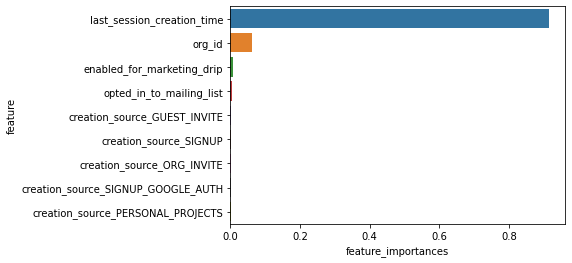

In [133]:
sns.barplot(y='feature', x='feature_importances', data=feature_importances_df)

* According to the barplot above, the most important feature last_session_creation_time contribute about 91.5% information on predicting the 'adopted user' in the Gradient Boosting Classifier. The second one is org_id, which is about 6.2%. The rest of the features are about 2.3% in total.